# **Project Overview** 
As the capabilities of Large Language Models (LLMs) continue to grow, evaluating their performance has become more important than ever, especially in the face of the biases that can be embedded in them [1]. Human evaluation of LLMs is crucial, yet poses a variety of challenges due to the inherently subjective nature of human assessments. What one user considers to be a “good” response may not be perceived as such by another user, leading to inconsistent feedback of LLM performance [2]. Additionally, there is currently no “standard” methodology or consensus on best practices for the human evaluation of LLMs, making it challenging to compare different research results studying their performance [3]. Ultimately, these factors make it difficult to integrate stable human evaluations into the development and refinement process of LLMs. 


In an effort to address this gap, a group of researchers created the “Chatbot Arena,” which is “an open platform for evaluating LLMs based on human preferences” [4]. Much like using a traditional LLM, users can pose questions (hereinafter referred to as “prompts”) and receive answers (hereinafter referred to as “responses”) from an LLM. However, unlike traditional LLMs, users receive two different responses from two different models presented side-by-side. The user is asked to select the response they prefer or select a tie. The model is anonymous, meaning that the user does not know which model produced the responses until after they have selected the winner. This eliminates any potential biases that might arise from name recognition or previous experiences with specific models.


Using a select dataset of over 17,000 conversations from the Chatbot Arena, we attempt to investigate and understand user preferences in various LLM interactions. Based on the user’s prompt, the two model responses, the selected “winner,” topic modeling data, and the prompt’s hardness scores, we attempt to complete two primary tasks. The first task (Task A) is the prediction of the winning model between Model A and Model B. The second task (Task B) is the prediction of the hardness score of the user’s prompt. 


The research questions for this project are as follows:
* **RQ1:** *Can we use logistic regression to predict if “Model A” or “Model B” will be selected as the winner by a random user in a Chatbot Arena “battle”?*
* **RQ2:** *Can we use linear regression to predict the hardness score of a given prompt?*

***In this notebook, you will the find exploratory data analysis conducted to better understand the dataset. It is the first of two notebooks used for this project.***

# **1. Obtain and Clean the Data**

In [4]:
# IMPORTS
from collections import defaultdict  # https://docs.python.org/3/library/collections.html Return a new dictionary-like object.
import json, math, gdown
import numpy as np
import pandas as pd
import plotly.express as px
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:.2f}'.format

In [5]:
# Read the JSON file into a DataFrame
url_conversations = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/chatbot-arena-conversations.jsonl.gz"

conversations = pd.read_json(url_conversations, lines=True)

# Display the first row of the data
conversations.head(1)

question_id     model_a    model_b   winner  \
0  58210e39b3fd4441a2bd4a518bb44c2d  chatglm-6b  koala-13b  model_b   

            judge                                     conversation_a  \
0  arena_user_973  [{'content': 'What is the difference between O...   

                                      conversation_b  
0  [{'content': 'What is the difference between O...

In [6]:
import requests
import numpy as np
from io import BytesIO

# URL of the raw .npy file
embeddings_url = "https://github.com/dychenster/nlp-chatarena/blob/main/chatbot-arena-prompts-embeddings.npy?raw=true"

# Use requests to get the file content
response = requests.get(embeddings_url)

# Make sure the request was successful
if response.status_code == 200:
    # Load the content into a numpy array
    content = BytesIO(response.content)
    embeddings = np.load(content)
    print("Embeddings loaded successfully into Colab.")
else:
    print(f"Failed to load the file. Status code: {response.status_code}")


Embeddings loaded successfully into Colab.


In [7]:
# Examine data types of each column
conversations.dtypes

question_id       object
model_a           object
model_b           object
winner            object
judge             object
conversation_a    object
conversation_b    object
dtype: object

In [8]:
# Examine null values in dataframe
conversations.isnull().sum()

question_id       0
model_a           0
model_b           0
winner            0
judge             0
conversation_a    0
conversation_b    0
dtype: int64

In [9]:
# Examine the winner types
conversations["winner"].value_counts()

winner
model_a          9019
model_b          8873
tie (bothbad)    4641
tie              2789
Name: count, dtype: int64

FIG.1a


Text(0, 0.5, 'Count')

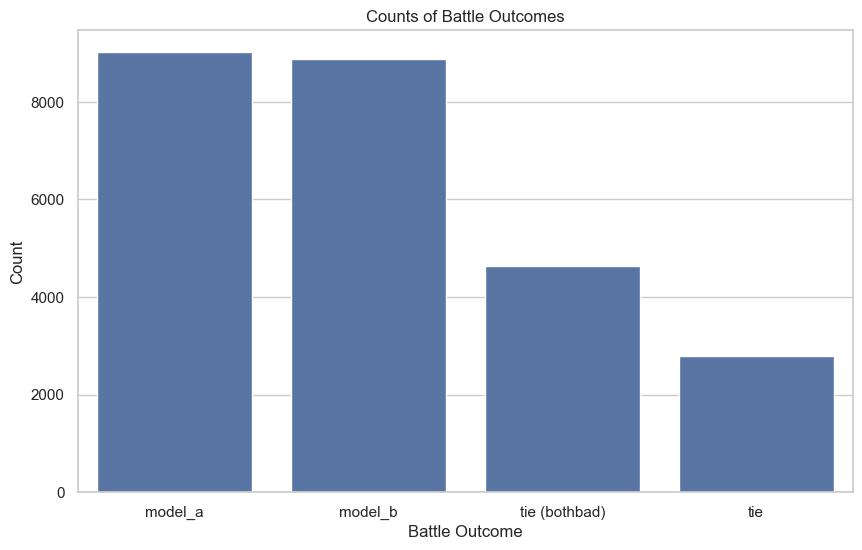

In [10]:
print("FIG.1a")

winner_counts = conversations["winner"].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=winner_counts.index, y=winner_counts.values)
plt.title('Counts of Battle Outcomes')
plt.xlabel('Battle Outcome')
plt.ylabel('Count')

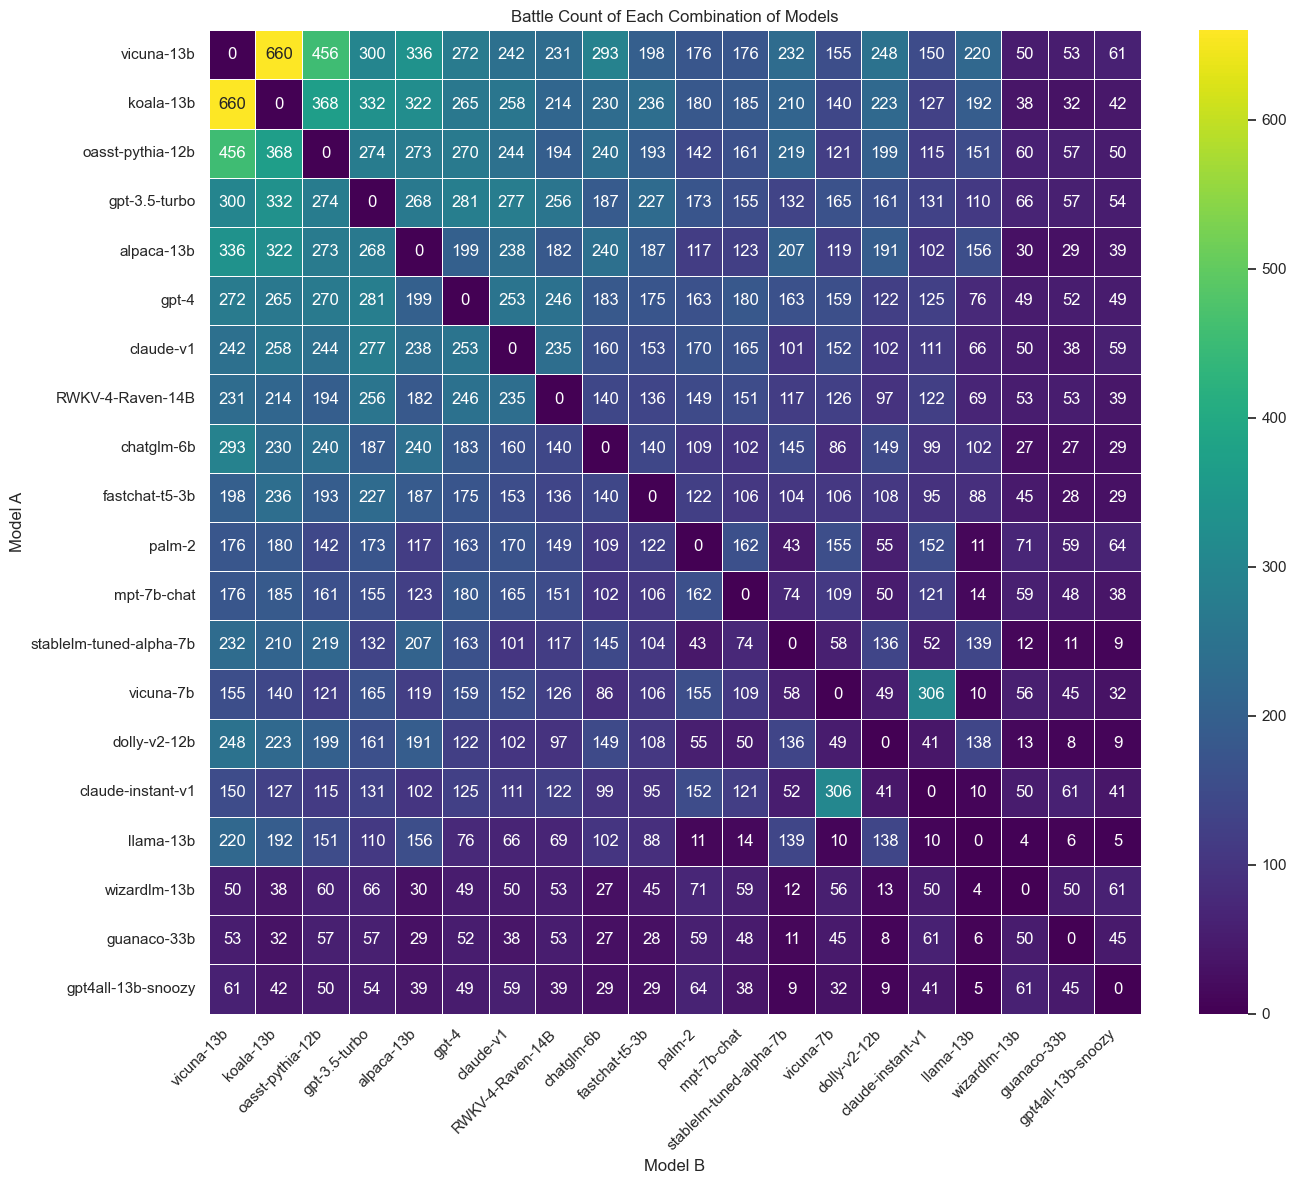

In [11]:
# Function to create battle matrix
def visualize_battle_count(battles, title):
    ptbl = pd.pivot_table(battles, index="model_a", columns="model_b", aggfunc="size", fill_value=0)
    battle_counts = ptbl + ptbl.T
    ordering = battle_counts.sum().sort_values(ascending=False).index
    battle_counts = battle_counts.loc[ordering, ordering]

    plt.figure(figsize=(14, 12))
    ax = sns.heatmap(battle_counts, annot=True, fmt="d", cmap="viridis", linewidths=.5)
    ax.set_title(title)
    ax.set_xlabel('Model B')
    ax.set_ylabel('Model A')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Create matrix of conversations data
visualize_battle_count(conversations, title="Battle Count of Each Combination of Models")

In [12]:
# Remove rows with tie (bothbad) and tie as winners
conversations = conversations.loc[~conversations["winner"].isin(["tie (bothbad)", "tie"])]

# Verify new winner types
conversations["winner"].value_counts()

winner
model_a    9019
model_b    8873
Name: count, dtype: int64

In [13]:
# Create a prompt column
conversations["prompt"] = conversations["conversation_a"].str[0].str["content"]
conversations["prompt"].head(1)

0    What is the difference between OpenCL and CUDA?
Name: prompt, dtype: object

In [14]:
# Summary statistics of the length of prompts
conversations["prompt_length"] = conversations["prompt"].str.len()
conversations["prompt_length"].describe()

count   17892.00
mean      197.51
std       374.50
min        16.00
25%        42.00
50%        70.00
75%       150.00
max      2560.00
Name: prompt_length, dtype: float64

FIG.2


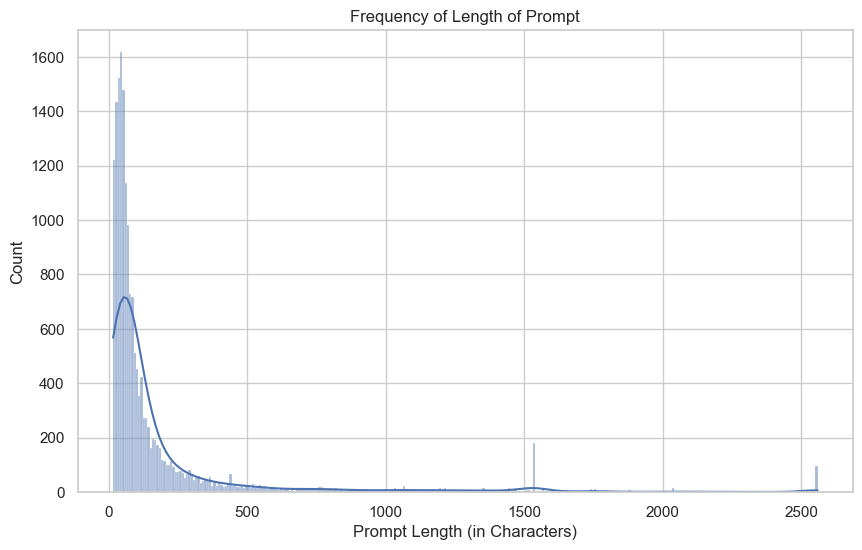

In [15]:
print("FIG.2")

# Plot the distribution of the length of the prompt
plt.figure(figsize=(10, 6))
plt.title("Frequency of Length of Prompt")
plt.xlabel("Prompt Length (in Characters)")
plt.ylabel("Count")
sns.histplot(conversations["prompt_length"], kde=True);

In [16]:
# Provide the raw URL of the JSON file
url_scores = "https://raw.githubusercontent.com/dychenster/nlp-chatarena/main/chatbot-arena-gpt3-scores.jsonl.gz"

# Read the JSON file into a DataFrame
topic_and_hardness = pd.read_json(url_scores, lines=True)

# Display the first row of the data
topic_and_hardness.head(1)

question_id  \
0  58210e39b3fd4441a2bd4a518bb44c2d   

                                            prompt  \
0  What is the difference between OpenCL and CUDA?   

                    openai_scores_raw_choices_nested      topic_modeling_1  \
0  [{'finish_reason': 'stop', 'index': 0, 'logpro...  Technical Comparison   

                                      score_reason_1 score_value_1  \
0  This prompt requires the AI to accurately comp...             9   

      topic_modeling_2                                     score_reason_2  \
0  Software Comparison  This prompt assesses the AI's factual accuracy...   

  score_value_2        topic_modeling_3  \
0             8  Comparison, Technology   

                                      score_reason_3 score_value_3  
0  This prompt requires the AI to demonstrate kno...             9

In [17]:
# Examine data types of each column
topic_and_hardness.dtypes

question_id                         object
prompt                              object
openai_scores_raw_choices_nested    object
topic_modeling_1                    object
score_reason_1                      object
score_value_1                       object
topic_modeling_2                    object
score_reason_2                      object
score_value_2                       object
topic_modeling_3                    object
score_reason_3                      object
score_value_3                       object
dtype: object

In [18]:
# Examine null values in dataframe
topic_and_hardness.isnull().sum()

question_id                          0
prompt                               0
openai_scores_raw_choices_nested     0
topic_modeling_1                    27
score_reason_1                      27
score_value_1                       27
topic_modeling_2                    27
score_reason_2                      27
score_value_2                       27
topic_modeling_3                    27
score_reason_3                      27
score_value_3                       27
dtype: int64

In [19]:
# Examine if there are any/how many null values are in the score values
display(topic_and_hardness["score_value_1"].isna().sum())
display(topic_and_hardness["score_value_2"].isna().sum())
display(topic_and_hardness["score_value_3"].isna().sum())

27

27

27

In [20]:
# Remove null values from scores values
topic_and_hardness = topic_and_hardness.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])
print(topic_and_hardness[['score_value_1', 'score_value_2', 'score_value_3']].isna().sum())

score_value_1    0
score_value_2    0
score_value_3    0
dtype: int64


In [21]:
# Check what the non-integer values are in score values
topic_and_hardness["score_value_1"][topic_and_hardness["score_value_1"].apply(
    lambda x: isinstance(x, list))].head()

12     [[8]]
54     [[7]]
92     [[7]]
150    [[8]]
187    [[7]]
Name: score_value_1, dtype: object

In [22]:
# Change all score values to be numeric
topic_and_hardness.loc[:,'score_value_1'] = pd.to_numeric(topic_and_hardness['score_value_1'], errors='coerce')
topic_and_hardness.loc[:,'score_value_2'] = pd.to_numeric(topic_and_hardness['score_value_2'], errors='coerce')
topic_and_hardness.loc[:,'score_value_3'] = pd.to_numeric(topic_and_hardness['score_value_3'], errors='coerce')

# Drop any resulting null values
topic_and_hardness= topic_and_hardness.dropna(subset=['score_value_1', 'score_value_2', 'score_value_3'])

# Change all score values to be integers
topic_and_hardness['score_value_1'] = topic_and_hardness['score_value_1'].astype(np.int64)
topic_and_hardness['score_value_2'] = topic_and_hardness['score_value_2'].astype(np.int64)
topic_and_hardness['score_value_3'] = topic_and_hardness['score_value_3'].astype(np.int64)

# Verify all score values are integers
topic_and_hardness.dtypes

question_id                         object
prompt                              object
openai_scores_raw_choices_nested    object
topic_modeling_1                    object
score_reason_1                      object
score_value_1                        int64
topic_modeling_2                    object
score_reason_2                      object
score_value_2                        int64
topic_modeling_3                    object
score_reason_3                      object
score_value_3                        int64
dtype: object

# **2. EDA**

## 2a. Ranking of the model based on their win rate.



In [23]:
# Calculate Win Rates

# Create a new column in df with the winner's name
conversations.loc[conversations["winner"] == "model_a", "winner_name"] = conversations["model_a"]
conversations.loc[conversations["winner"] == "model_b", "winner_name"] = conversations["model_b"]
conversations["winner_name"].value_counts()

# Calculate win rate of each model
win_rates = conversations["winner_name"].value_counts() / (conversations["model_a"].value_counts() + conversations["model_b"].value_counts())
win_rates.sort_values(ascending=False)

gpt-4                     0.85
claude-v1                 0.80
claude-instant-v1         0.76
gpt-3.5-turbo             0.71
vicuna-13b                0.62
guanaco-33b               0.60
palm-2                    0.59
wizardlm-13b              0.54
koala-13b                 0.51
vicuna-7b                 0.45
mpt-7b-chat               0.35
alpaca-13b                0.35
oasst-pythia-12b          0.35
gpt4all-13b-snoozy        0.34
RWKV-4-Raven-14B          0.34
chatglm-6b                0.30
fastchat-t5-3b            0.30
stablelm-tuned-alpha-7b   0.26
dolly-v2-12b              0.23
llama-13b                 0.20
Name: count, dtype: float64

FIG. 3


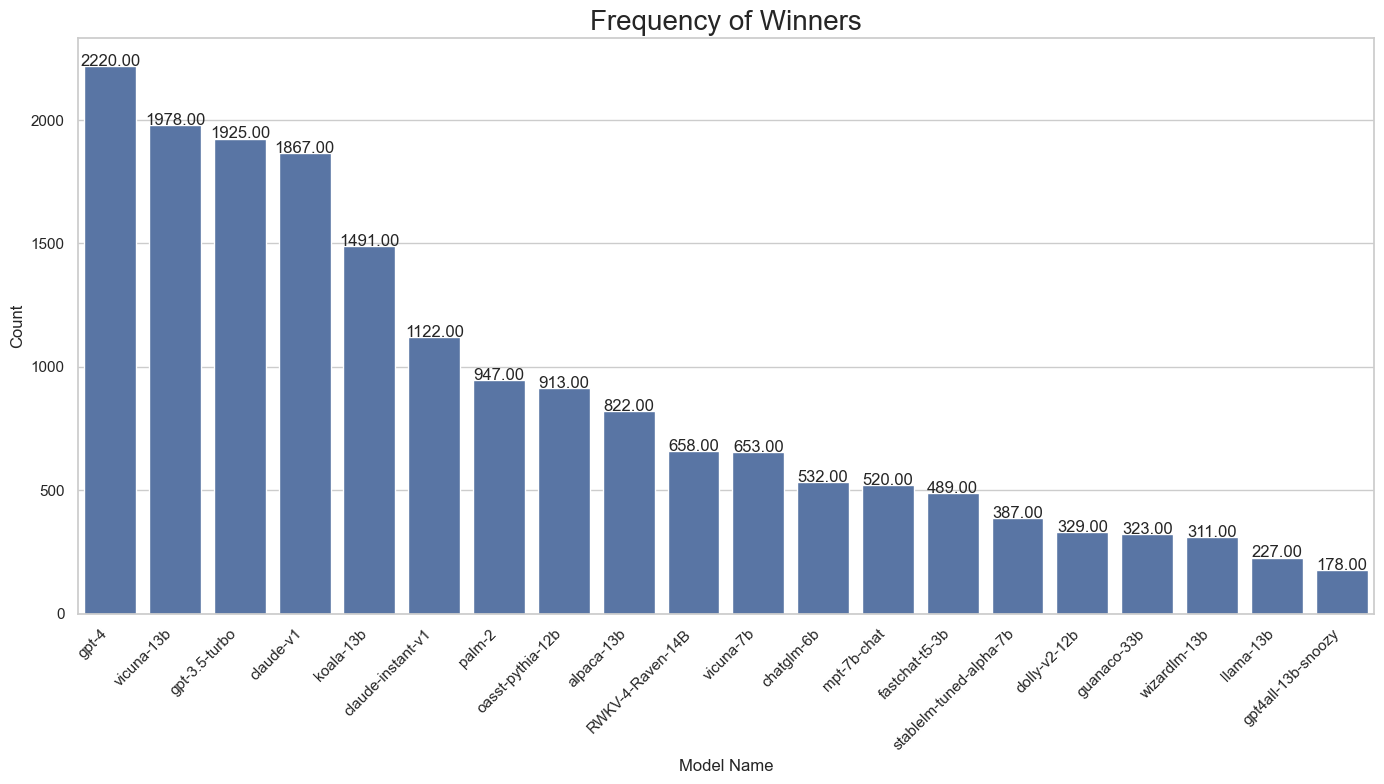

In [33]:
print("FIG. 3")

winner_name_counts = conversations['winner_name'].value_counts()

plt.figure(figsize=(14, 8))
sns.barplot(x=winner_name_counts.index, y=winner_name_counts.values)# palette='viridis')
plt.title('Frequency of Winners', fontsize=20)
plt.xlabel('Model Name')
plt.ylabel('Count')

# Add text annotations on the bars
for i, value in enumerate(winner_name_counts.values):
    plt.text(i, value + 0.5, f'{value:.2f}', ha='center')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

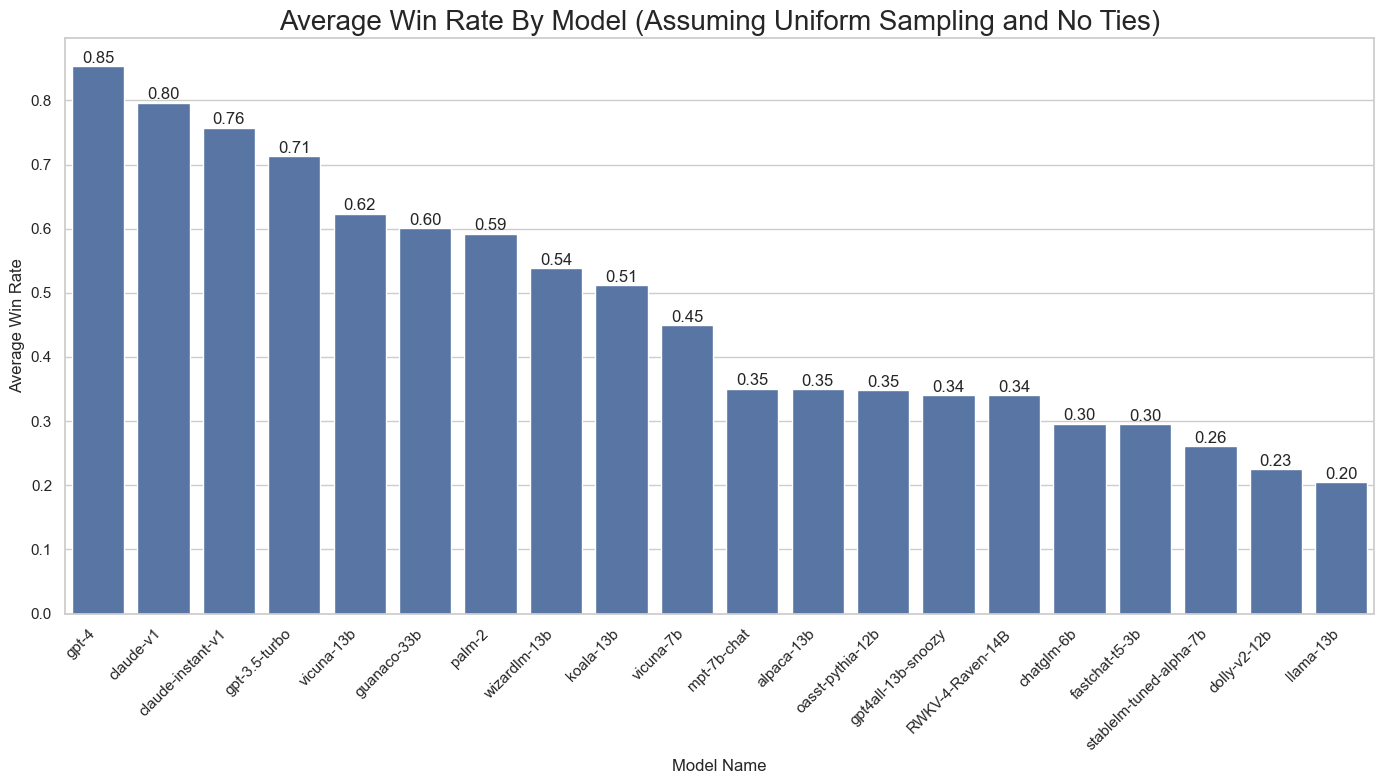

In [32]:
win_rates_sorted = win_rates.sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=win_rates_sorted.index, y=win_rates_sorted.values)# palette='viridis')
plt.title('Average Win Rate By Model (Assuming Uniform Sampling and No Ties)', fontsize=20)
plt.xlabel('Model Name')
plt.ylabel('Average Win Rate')

# Add text annotations on the bars
for i, value in enumerate(win_rates_sorted.values):
    plt.text(i, value + 0.005, f'{value:.2f}', ha='center')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## **2b. Distribution of the prompt and response length.**

FIG.5a


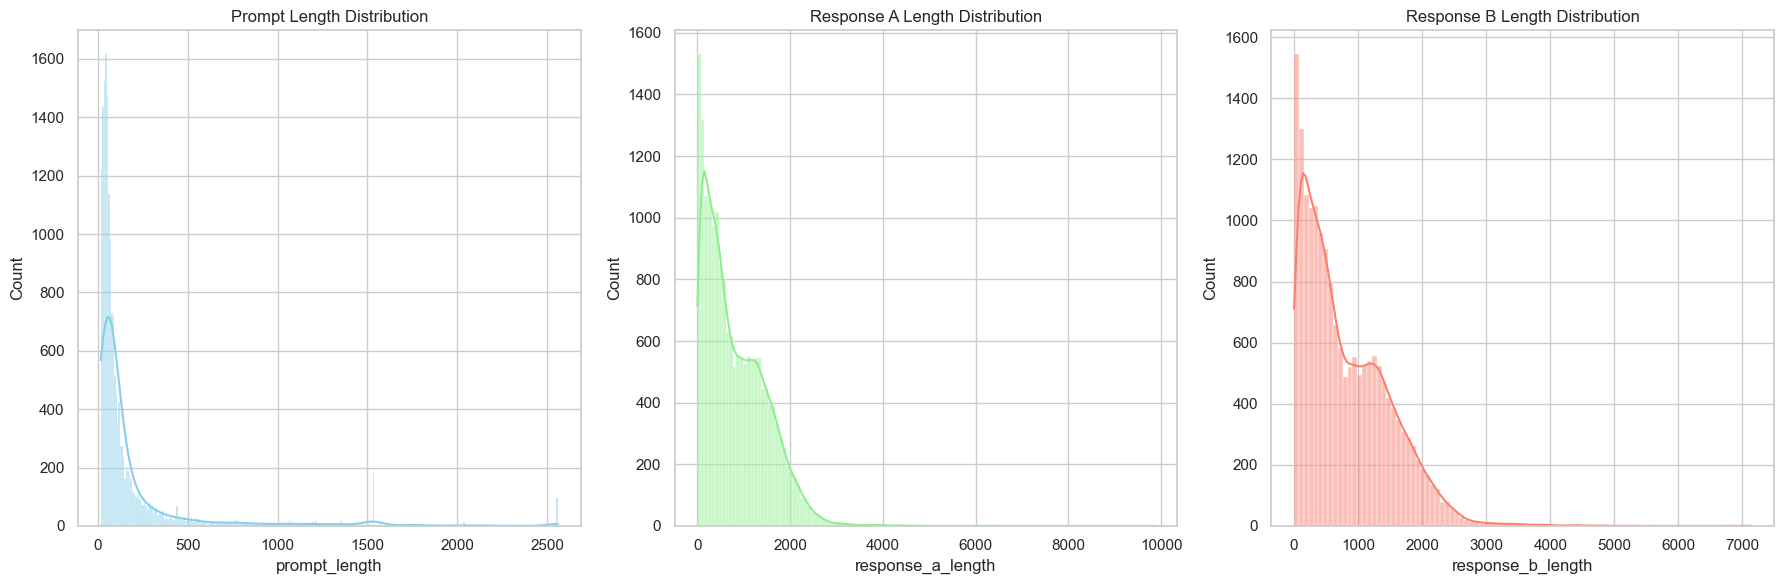

In [34]:
print("FIG.5a")

# Create new columns in df with the length of both responses
conversations["response_a_length"] = conversations["conversation_a"].str[1].str["content"].str.len()
conversations["response_b_length"] = conversations["conversation_b"].str[1].str["content"].str.len()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(data=conversations, x="prompt_length", color="skyblue", kde=True)
plt.title("Prompt Length Distribution")

plt.subplot(1, 3, 2)
sns.histplot(data=conversations, x="response_a_length", color="lightgreen", kde=True)
plt.title("Response A Length Distribution")

plt.subplot(1, 3, 3)
sns.histplot(data=conversations, x="response_b_length", color="salmon", kde=True)
plt.title("Response B Length Distribution")

plt.tight_layout()
plt.show();

FIG.5b


/Users/dianachen/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dianachen/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


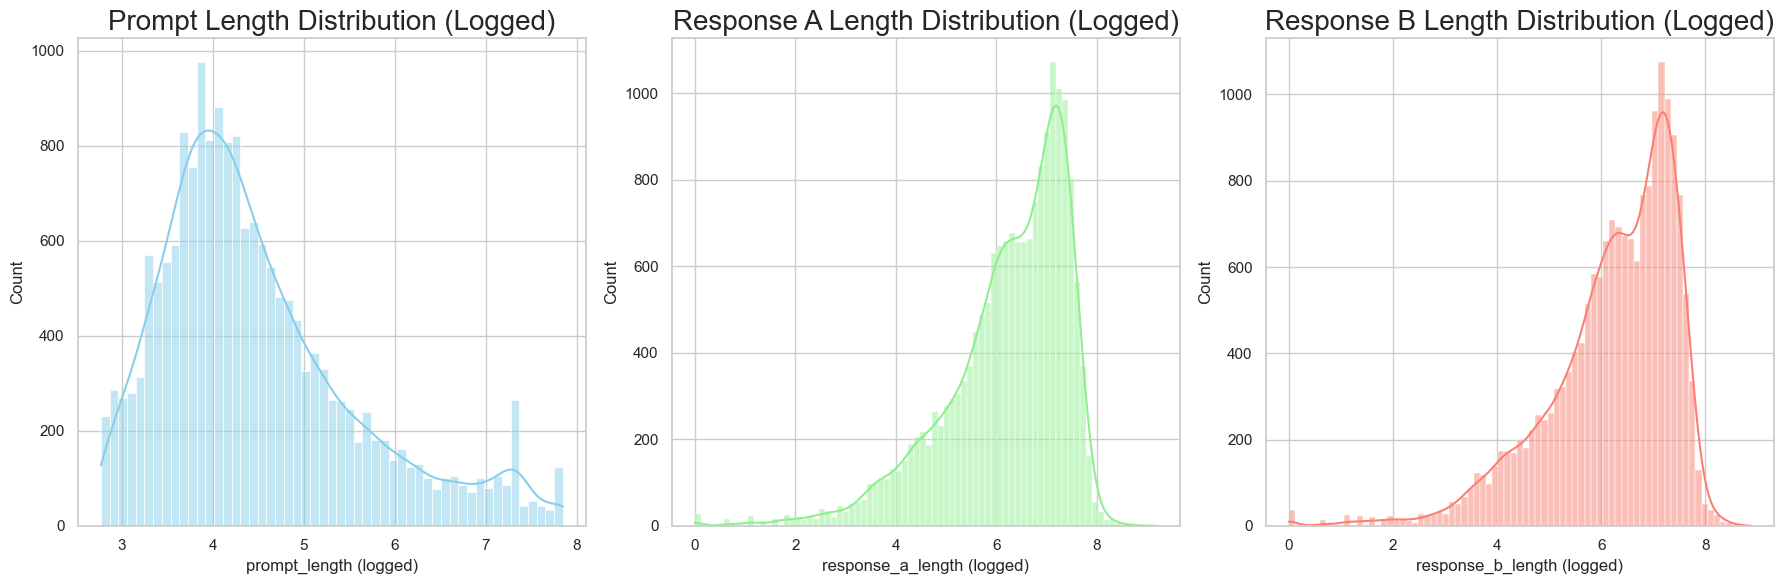

In [47]:
print("FIG.5b")

# Log transformed lengths to view any patterns in distribution of values

# Create new columns in df with the length of both responses
conversations["prompt_length (logged)"] = np.log(conversations["prompt_length"])
conversations["response_a_length (logged)"] = np.log(conversations["conversation_a"].str[1].str["content"].str.len())
conversations["response_b_length (logged)"] = np.log(conversations["conversation_b"].str[1].str["content"].str.len())

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(data=conversations, x="prompt_length (logged)", color="skyblue", kde=True)
plt.title("Prompt Length Distribution (Logged)", fontsize=20)

plt.subplot(1, 3, 2)
sns.histplot(data=conversations, x="response_a_length (logged)", color="lightgreen", kde=True)
plt.title("Response A Length Distribution (Logged)", fontsize=20)

plt.subplot(1, 3, 3)
sns.histplot(data=conversations, x="response_b_length (logged)", color="salmon", kde=True)
plt.title("Response B Length Distribution (Logged)", fontsize=20)

plt.tight_layout()
plt.show();

In [42]:
conversations["response_a_length (logged)"]

0       6.79
2       7.02
3       7.36
4       5.59
5       5.18
        ... 
25313   6.81
25314   6.11
25317   4.96
25319   7.61
25320   7.59
Name: response_a_length (logged), Length: 17892, dtype: float64

FIG. 5c


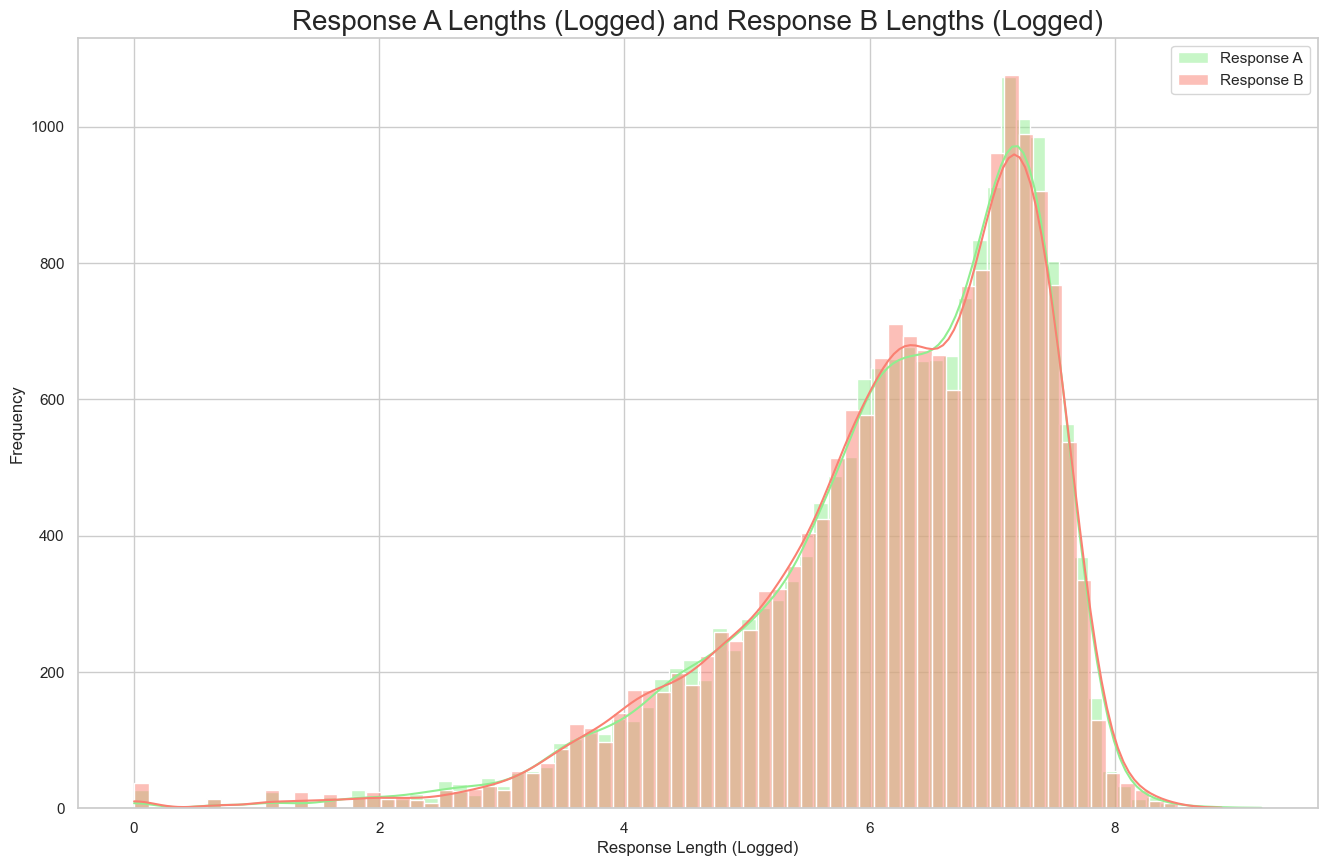

In [45]:
print("FIG. 5c")

# Compare distribution of response lengths for A and B
plt.figure(figsize=(16, 10))

sns.histplot(data=conversations, x="response_a_length (logged)", color="lightgreen", kde=True, label="Response A")
sns.histplot(data=conversations, x="response_b_length (logged)", color="salmon", kde=True, label="Response B")

# Labels
plt.title("Response A Lengths (Logged) and Response B Lengths (Logged)", fontsize=20)
plt.xlabel("Response Length (Logged)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## **2c. Hardness score distribution and its correlation with the models**:

In [48]:
# Reference topic and hardness scores attributed to each battle
display(topic_and_hardness.head())
display(conversations.head())

question_id  \
0  58210e39b3fd4441a2bd4a518bb44c2d   
1  2564acd09e3942fd97657d05282d4389   
2  90bfd142157948aba01931726c888e7f   
3  a7c5accc53e649a3bc6b2e41d962ebc4   
4  adf27e819a3c494cb6e993f0c660e097   

                                              prompt  \
0    What is the difference between OpenCL and CUDA?   
1  Why did my parent not invite me to their wedding?   
2                   Fuji vs. Nikon, which is better?   
3                How to build an arena for chatbots?   
4                                  When is it today?   

                    openai_scores_raw_choices_nested      topic_modeling_1  \
0  [{'finish_reason': 'stop', 'index': 0, 'logpro...  Technical Comparison   
1  [{'finish_reason': 'stop', 'index': 0, 'logpro...    Reasoning, Emotion   
2  [{'finish_reason': 'stop', 'index': 0, 'logpro...     Camera comparison   
3  [{'finish_reason': 'stop', 'index': 0, 'logpro...         Chatbot Arena   
4  [{'finish_reason': 'stop', 'index': 0, 'logpro...            Time Query   

                                      score_reason_1  score_value_1  \
0  This prompt requires the AI to accurately comp...              9   
1  This prompt requires the AI to understand huma...              9   
2  This prompt does not require problem-solving s...              2   
3  This prompt requires problem-solving skills an...              8   
4  This prompt is very straightforward and does n...              2   

          topic_modeling_2                                     score_reason_2  \
0      Software Comparison  This prompt assesses the AI's factual accuracy...   
1  Emotions, Relationships  This prompt involves understanding complex hum...   
2     Comparative Analysis  This prompt assesses the AI's ability to analy...   
3            Chatbot Arena  This prompt requires the AI to engage in probl...   
4             Date Inquiry  This prompt is very straightforward and does n...   

   score_value_2        topic_modeling_3  \
0              8  Comparison, Technology   
1              8    Reasoning, Emotional   
2              6  Photography comparison   
3              8           Chatbot Arena   
4              2      Time-based Inquiry   

                                      score_reason_3  score_value_3  
0  This prompt requires the AI to demonstrate kno...              9  
1  This prompt challenges the AI to infer motives...              8  
2  This prompt is subjective and does not provide...              2  
3  This prompt requires problem-solving skills an...              8  
4  This prompt is too straightforward and simply ...              2

question_id     model_a           model_b   winner  \
0  58210e39b3fd4441a2bd4a518bb44c2d  chatglm-6b         koala-13b  model_b   
2  90bfd142157948aba01931726c888e7f   koala-13b  oasst-pythia-12b  model_b   
3  a7c5accc53e649a3bc6b2e41d962ebc4  vicuna-13b  oasst-pythia-12b  model_b   
4  adf27e819a3c494cb6e993f0c660e097  vicuna-13b         koala-13b  model_a   
5  c0fc42c6f5f14f2aa5a89f71f8553730  vicuna-13b         koala-13b  model_a   

            judge                                     conversation_a  \
0  arena_user_973  [{'content': 'What is the difference between O...   
2  arena_user_973  [{'content': 'Fuji vs. Nikon, which is better?...   
3  arena_user_973  [{'content': 'How to build an arena for chatbo...   
4  arena_user_973  [{'content': 'When is it today?', 'role': 'use...   
5  arena_user_973  [{'content': 'Count from 1 to 10 with step = 3...   

                                      conversation_b  \
0  [{'content': 'What is the difference between O...   
2  [{'content': 'Fuji vs. Nikon, which is better?...   
3  [{'content': 'How to build an arena for chatbo...   
4  [{'content': 'When is it today?', 'role': 'use...   
5  [{'content': 'Count from 1 to 10 with step = 3...   

                                            prompt  prompt_length  \
0  What is the difference between OpenCL and CUDA?             47   
2                 Fuji vs. Nikon, which is better?             32   
3              How to build an arena for chatbots?             35   
4                                When is it today?             17   
5                 Count from 1 to 10 with step = 3             32   

        winner_name  response_a_length  response_b_length  \
0         koala-13b                892               1905   
2  oasst-pythia-12b               1114               1566   
3  oasst-pythia-12b               1575               1624   
4        vicuna-13b                267                 27   
5        vicuna-13b                178                 11   

   prompt_length (logged)  response_a_length (logged)  \
0                    3.85                        6.79   
2                    3.47                        7.02   
3                    3.56                        7.36   
4                    2.83                        5.59   
5                    3.47                        5.18   

   response_b_length (logged)  
0                        7.55  
2                        7.36  
3                        7.39  
4                        3.30  
5                        2.40

In [49]:
# Examine rationale structure of score choice
topic_and_hardness['openai_scores_raw_choices_nested'][0]

[{'finish_reason': 'stop',
  'index': 0,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeling": "Technical Comparison",\n    "score_reason": "This prompt requires the AI to accurately compare and contrast two distinct technologies, OpenCL and CUDA. It assesses the AI\'s factual accuracy and knowledge of these technologies, as well as its ability to articulate the differences between them.",\n    "score_value": 9\n}',
   'role': 'assistant',
   'function_call': None,
   'tool_calls': None}},
 {'finish_reason': 'stop',
  'index': 1,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeling": "Software Comparison",\n    "score_reason": "This prompt assesses the AI\'s factual accuracy in distinguishing between two similar but distinct software frameworks.",\n    "score_value": 8\n}',
   'role': 'assistant',
   'function_call': None,
   'tool_calls': None}},
 {'finish_reason': 'stop',
  'index': 2,
  'logprobs': None,
  'message': {'content': '{\n    "topic_modeli

In [50]:
# Create new data frame of just hardness scores
hardness_df = conversations.merge(topic_and_hardness, on="question_id")[["question_id", "winner_name", "score_value_1", "score_value_2", "score_value_3"]]

# Add total (average) score for each battle
hardness_df["average_score"] = (hardness_df["score_value_1"] + hardness_df["score_value_2"] + hardness_df["score_value_3"])/ 3
hardness_df

question_id        winner_name  score_value_1  \
0      58210e39b3fd4441a2bd4a518bb44c2d          koala-13b              9   
1      90bfd142157948aba01931726c888e7f   oasst-pythia-12b              2   
2      a7c5accc53e649a3bc6b2e41d962ebc4   oasst-pythia-12b              8   
3      adf27e819a3c494cb6e993f0c660e097         vicuna-13b              2   
4      c0fc42c6f5f14f2aa5a89f71f8553730         vicuna-13b              7   
...                                 ...                ...            ...   
17040  cf48ede921a047d187aa029a7acd98dd     fastchat-t5-3b              7   
17041  471beeffa2d347a6bd499db66a74254c             palm-2              7   
17042  fb4d58ef8649472783d364a9c1c8239e             palm-2              7   
17043  86063a921be548989c55b85497ab009a  claude-instant-v1              8   
17044  f72930b382e949ea879e7abf3cb1e587        guanaco-33b              7   

       score_value_2  score_value_3  average_score  
0                  8              9           8.67  
1                  6              2           3.33  
2                  8              8           8.00  
3                  2              2           2.00  
4                  2              2           3.67  
...              ...            ...            ...  
17040              2              7           5.33  
17041              3              7           5.67  
17042              7              8           7.33  
17043              9              7           8.00  
17044              8              8           7.67  

[17045 rows x 6 columns]

FIG. 7a


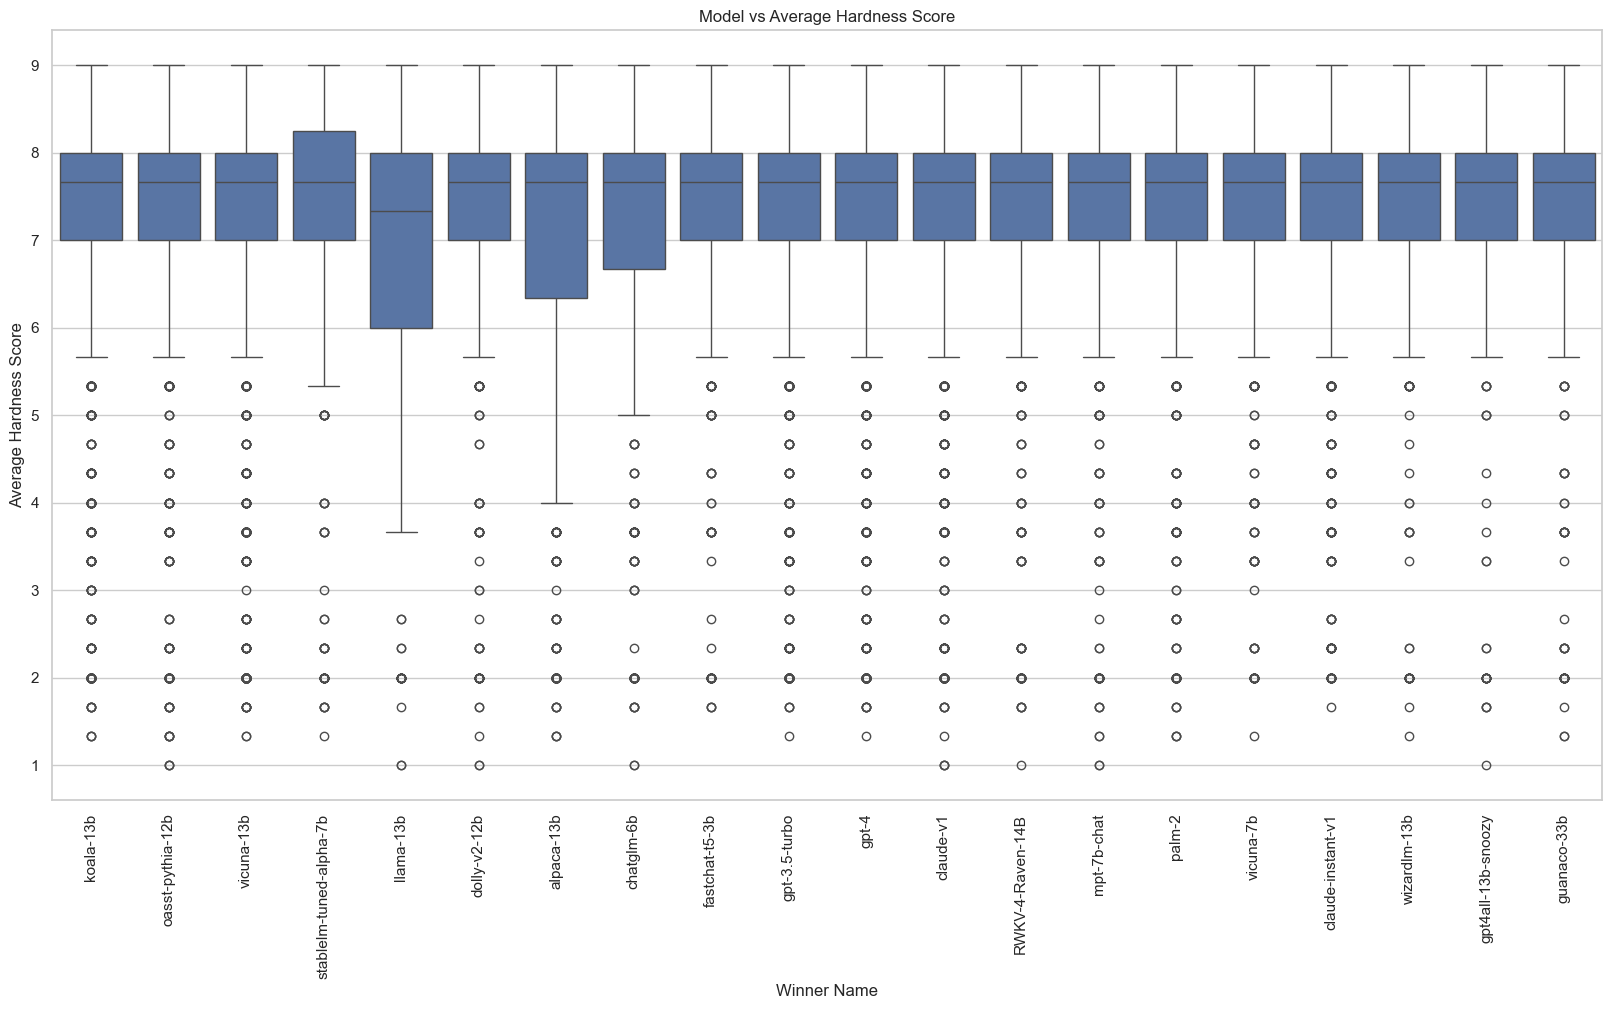

In [51]:
print("FIG. 7a")

plt.figure(figsize=(20, 10))

sns.boxplot(data=hardness_df, x="winner_name", y="average_score")
sns.set(font_scale=1)
plt.xticks(rotation=90)
plt.xlabel("Winner Name")
plt.ylabel("Average Hardness Score")
plt.title("Model vs Average Hardness Score");

FIG. 7b


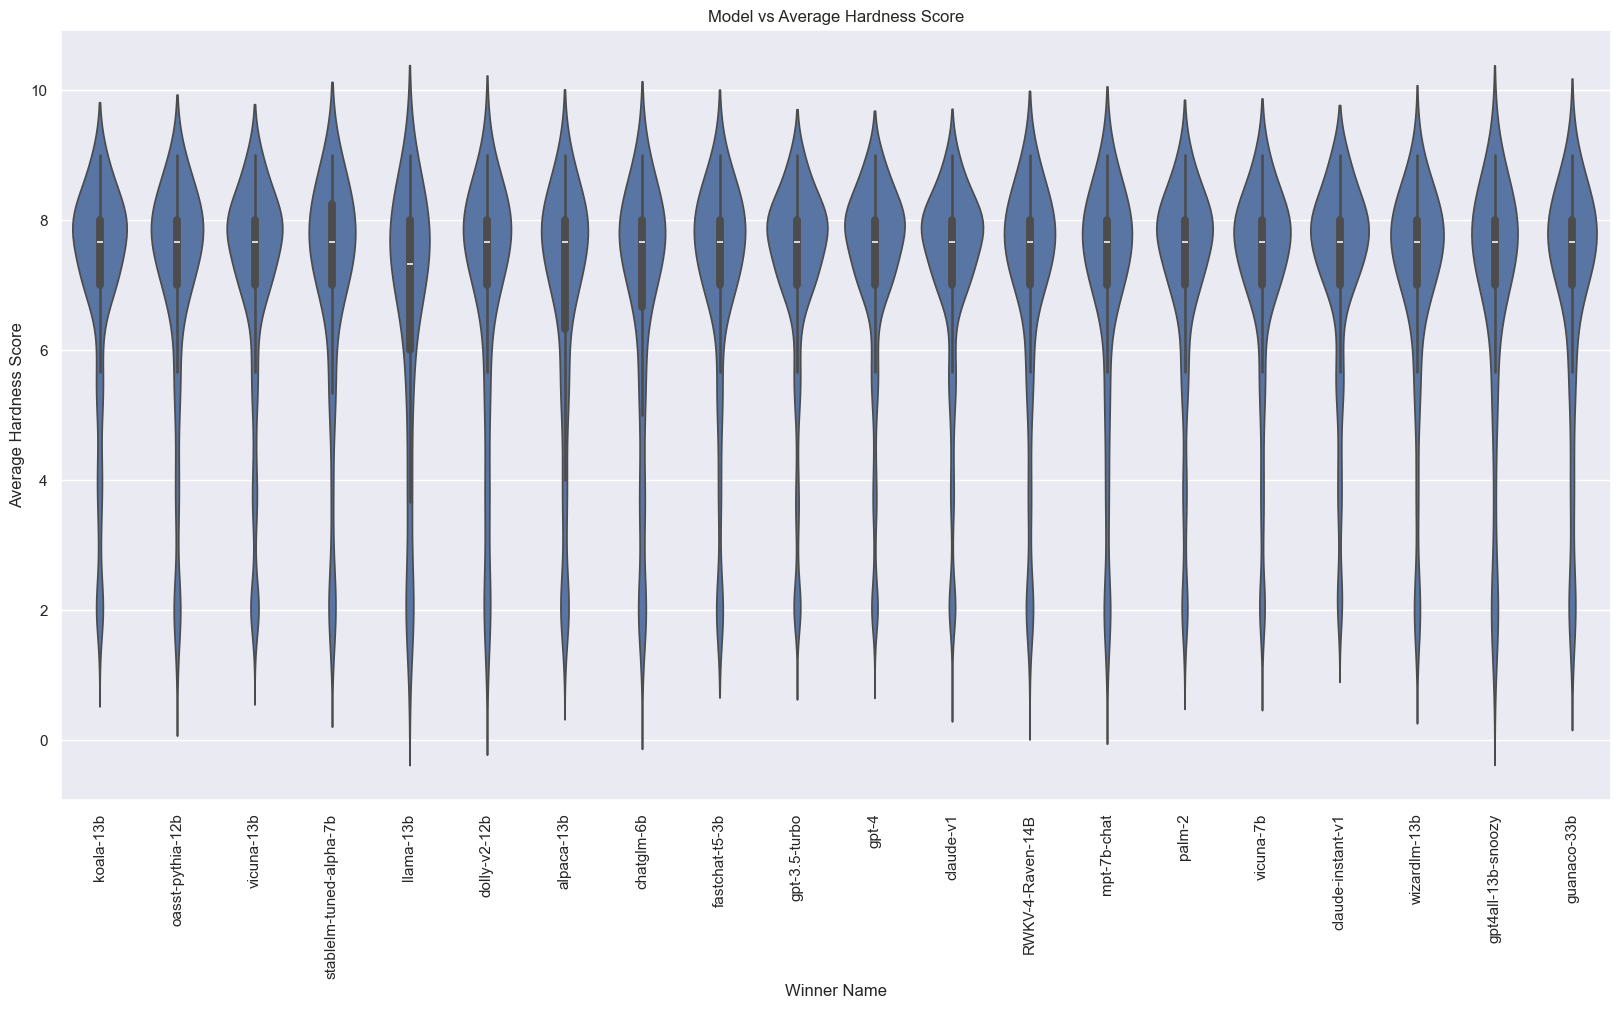

In [52]:
print("FIG. 7b")

plt.figure(figsize=(20, 10))

sns.violinplot(data=hardness_df, x="winner_name", y="average_score")
sns.set(font_scale=1)
plt.xticks(rotation=90)
plt.xlabel("Winner Name")
plt.ylabel("Average Hardness Score")
plt.title("Model vs Average Hardness Score");

In [53]:
average_hardness_per_model = hardness_df.groupby("winner_name")["average_score"].mean().sort_values(ascending=False)
average_hardness_per_model

winner_name
claude-instant-v1         7.26
gpt-4                     7.25
gpt-3.5-turbo             7.22
vicuna-7b                 7.21
claude-v1                 7.20
palm-2                    7.14
fastchat-t5-3b            7.12
wizardlm-13b              7.10
oasst-pythia-12b          7.07
vicuna-13b                7.07
koala-13b                 7.06
RWKV-4-Raven-14B          7.05
stablelm-tuned-alpha-7b   7.05
mpt-7b-chat               7.00
guanaco-33b               6.97
gpt4all-13b-snoozy        6.93
dolly-v2-12b              6.91
alpaca-13b                6.84
chatglm-6b                6.81
llama-13b                 6.67
Name: average_score, dtype: float64

FIG. 8


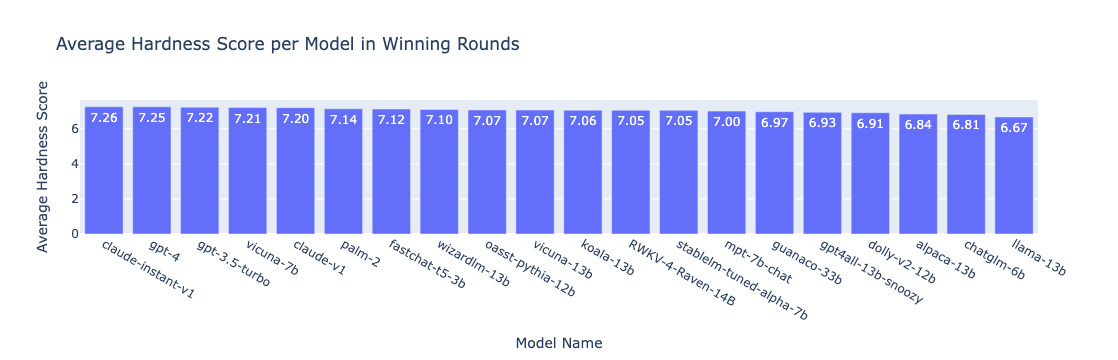

In [54]:
print("FIG. 8")

fig = px.bar(average_hardness_per_model,
             title="Average Hardness Score per Model in Winning Rounds",
             text_auto=".2f")
fig.update_layout(yaxis_title="Average Hardness Score", xaxis_title="Model Name",
                  showlegend=False)
fig

In [ ]:
average_hardness_per_model_sorted = hardness_df["average_score"].sort_values(ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x=average_hardness_per_model_sorted.index, y=average_hardness_per_model_sorted.values) #, palette='viridis')
plt.title('Average Hardness Score per Model in Winning Rounds', fontsize=20)
plt.xlabel('Model Name')
plt.ylabel('Average Hardness Score')

# Add text annotations on the bars
for i, value in enumerate(average_hardness_per_model_sorted.values):
    plt.text(i, value + 0.005, f'{value:.2f}', ha='center')

plt.xticks(rotation=45, ha='right')
#plt.tight_layout()
plt.show()

## **2d (Open-ended) Visualize the “variance” in model performance (see LMSys Leaderboard for an example)**:

In [80]:
# Create list of names
names_list = winner_name_counts.index.tolist()

# Create list to collect variances
variance_list = []

for name in names_list:
    n = len(hardness_df[hardness_df['winner_name'] == name])
    score = hardness_df[hardness_df['winner_name'] == name]['average_score']
    mean_score = np.mean(hardness_df[hardness_df['winner_name'] == name]['average_score'])

    # Add variance to list
    variance_list.append(sum((score - mean_score)**2) / (n - 1))

print(variance_list)

[2.5270225283707584, 3.1705757226107063, 2.5570000790954026, 2.569561244198593, 3.0559744398449413, 2.436523816028335, 2.786403034364969, 3.2951551845718803, 3.732999775180909, 3.2292640052885977, 2.507112647966309, 3.9353527571255613, 3.3620503296003825, 2.995301363655096, 3.4196283924244772, 3.742286480150556, 3.438936608892673, 2.829891987132357, 4.153282698981617, 3.7388622773238147]


In [81]:
print("FIG. 9a")

average_hardness_per_model_df = hardness_df.groupby("winner_name")[["average_score"]].mean().sort_values(by = "average_score", ascending=False).reset_index()


variance_leaderboard = (pd.DataFrame({'Name': names_list, 'Variance': variance_list})
                        .sort_values('Variance', ascending=False)
                        .merge(average_hardness_per_model_df, left_on='Name', right_on='winner_name')
                        .drop(columns='winner_name')
                        .rename(columns= {"average_score": "Avg_Hardness_Score"}))

display(variance_leaderboard)

FIG. 9a


Name  Variance  Avg_Hardness_Score
0                 llama-13b      4.15                6.67
1                chatglm-6b      3.94                6.81
2              dolly-v2-12b      3.74                6.91
3        gpt4all-13b-snoozy      3.74                6.93
4                alpaca-13b      3.73                6.84
5               guanaco-33b      3.44                6.97
6   stablelm-tuned-alpha-7b      3.42                7.05
7               mpt-7b-chat      3.36                7.00
8          oasst-pythia-12b      3.30                7.07
9          RWKV-4-Raven-14B      3.23                7.05
10               vicuna-13b      3.17                7.07
11                koala-13b      3.06                7.06
12           fastchat-t5-3b      3.00                7.12
13             wizardlm-13b      2.83                7.10
14                   palm-2      2.79                7.14
15                claude-v1      2.57                7.20
16            gpt-3.5-turbo      2.56                7.22
17                    gpt-4      2.53                7.25
18                vicuna-7b      2.51                7.21
19        claude-instant-v1      2.44                7.26

FIG. 9b


/Users/dianachen/Library/Python/3.9/lib/python/site-packages/seaborn/axisgrid.py:123: UserWarning:

The figure layout has changed to tight



<Figure size 2000x1200 with 0 Axes>

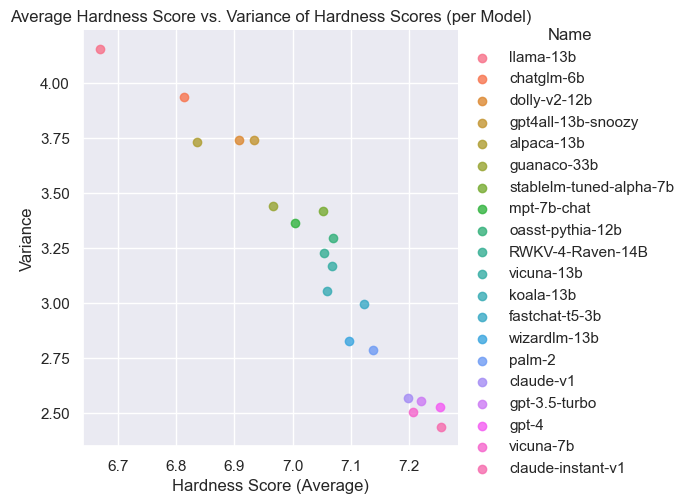

In [82]:
print("FIG. 9b")

plt.figure(figsize=(20, 12))
sns.lmplot(data=variance_leaderboard, x='Avg_Hardness_Score', y='Variance', hue='Name', fit_reg=False)
plt.title("Average Hardness Score vs. Variance of Hardness Scores (per Model)")
plt.xlabel("Hardness Score (Average)")
plt.ylabel("Variance")
plt.show();

## **2e.(Open-ended) Explore the prompt topics in the dataset (topic modeling).**

In [83]:
topic_and_hardness[["topic_modeling_1", "topic_modeling_2", "topic_modeling_3"]]

topic_modeling_1  \
0           Technical Comparison   
1             Reasoning, Emotion   
2              Camera comparison   
3                  Chatbot Arena   
4                     Time Query   
...                          ...   
25317   Mathematics, Measurement   
25318      Information Retrieval   
25319  Training, Hyperparameters   
25320          Language Modeling   
25321        Workflow Automation   

                                     topic_modeling_2  \
0                                 Software Comparison   
1                             Emotions, Relationships   
2                                Comparative Analysis   
3                                       Chatbot Arena   
4                                        Date Inquiry   
...                                               ...   
25317                        Mathematical Calculation   
25318                                  Factual Recall   
25319  Machine Learning - Hyperparameter Optimization   
25320                       Language Model Evaluation   
25321                             Workflow Automation   

                   topic_modeling_3  
0            Comparison, Technology  
1              Reasoning, Emotional  
2            Photography comparison  
3                     Chatbot Arena  
4                Time-based Inquiry  
...                             ...  
25317  Mathematics, Problem-solving  
25318             Factual knowledge  
25319              Machine Learning  
25320             Language modeling  
25321           Workflow Automation  

[24106 rows x 3 columns]

In [84]:
# Concatenate the three topic models columns
combined_topic_modeling = pd.concat([topic_and_hardness['topic_modeling_1'], topic_and_hardness['topic_modeling_2'], topic_and_hardness['topic_modeling_3']])
combined_topic_modeling.value_counts()

Creative Writing                   1655
Factual Accuracy                   1493
Problem-solving, Creativity        1108
Factual Knowledge                   898
Problem Solving                     828
                                   ... 
Entertainment, Idol                   1
Book Selection                        1
Embedded Systems, Configuration       1
Finance, Theory                       1
Relationship Management               1
Name: count, Length: 20931, dtype: int64

In [85]:
# Same as above but turns everything into lowercase

# Concatenate the three topic models columns
topic_and_hardness["topic_modeling_1_lower"] = topic_and_hardness["topic_modeling_1"].str.lower().str.replace('-', ' ')
topic_and_hardness["topic_modeling_2_lower"] = topic_and_hardness["topic_modeling_2"].str.lower().str.replace('-', ' ')
topic_and_hardness["topic_modeling_3_lower"] = topic_and_hardness["topic_modeling_3"].str.lower().str.replace('-', ' ')
# topic_and_hardness.head(1)

combined_topic_modeling_lower = pd.concat([topic_and_hardness['topic_modeling_1_lower'], topic_and_hardness['topic_modeling_2_lower'], topic_and_hardness['topic_modeling_3_lower']])
combined_topic_modeling_lower.value_counts()

creative writing               1775
problem solving, creativity    1660
factual accuracy               1582
problem solving                1329
factual knowledge               941
                               ... 
sport definition                  1
philosophy, coherence             1
physics, information              1
ai, problem solving               1
relationship management           1
Name: count, Length: 18918, dtype: int64

FIG. 10a


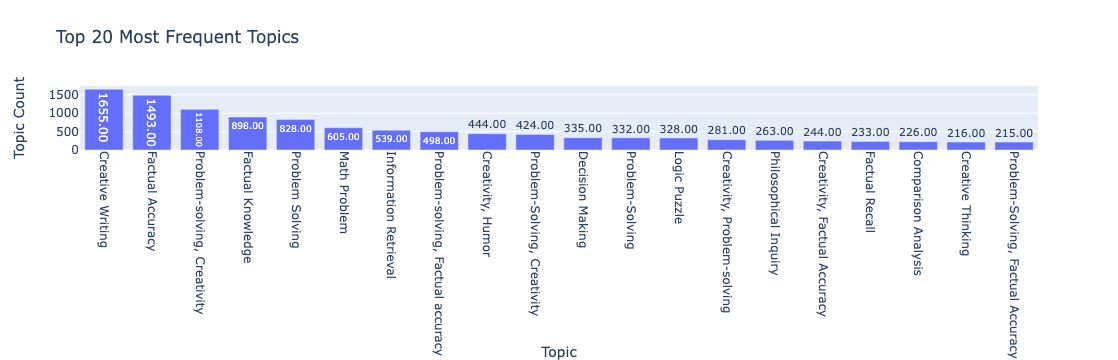

In [86]:
print("FIG. 10a")

# Look at the top 20 most frequent topics ()
top_20_topics = combined_topic_modeling.value_counts().head(20)
top_20_topics

# Visualize top 20 most frequent topics
fig = px.bar(top_20_topics.sort_values(ascending=False),
             title="Top 20 Most Frequent Topics",
             text_auto=".2f")
fig.update_layout(yaxis_title="Topic Count", xaxis_title="Topic",
                  showlegend=False)
fig.update_xaxes(tickangle=90)

fig

FIG. 10b


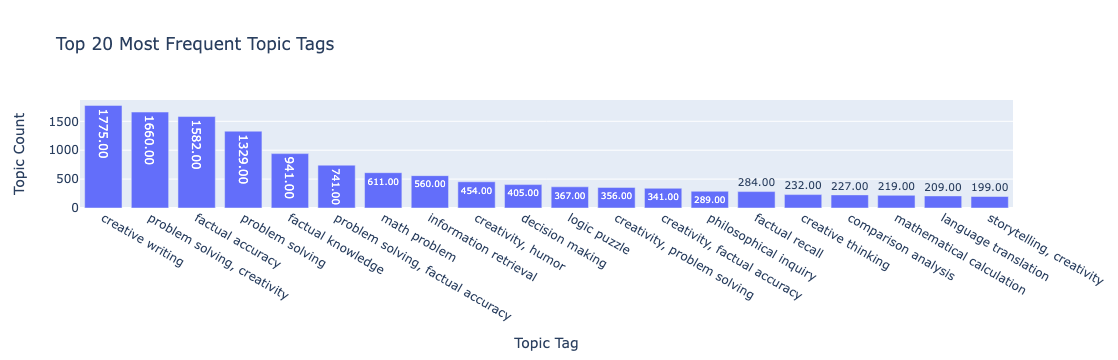

In [87]:
# Same as above but calculates based on everything lowercase
print("FIG. 10b")

# Look at the top 20 most frequent topics ()
top_20_topics_lower = combined_topic_modeling_lower.value_counts().head(20)
top_20_topics_lower

# Visualize top 20 most frequent topics
fig = px.bar(top_20_topics_lower.sort_values(ascending=False),
             title="Top 20 Most Frequent Topic Tags",
             text_auto=".2f")
fig.update_layout(yaxis_title="Topic Count", xaxis_title="Topic Tag",
                  showlegend=False)
fig

FIG. 10c


problem solving            4921
creativity                 2960
creative writing           1781
factual accuracy           1689
mathematics                1622
                           ... 
emoji communication           1
mechanism understanding       1
creative assessment           1
sport definition              1
relationship management       1
Name: count, Length: 13110, dtype: int64

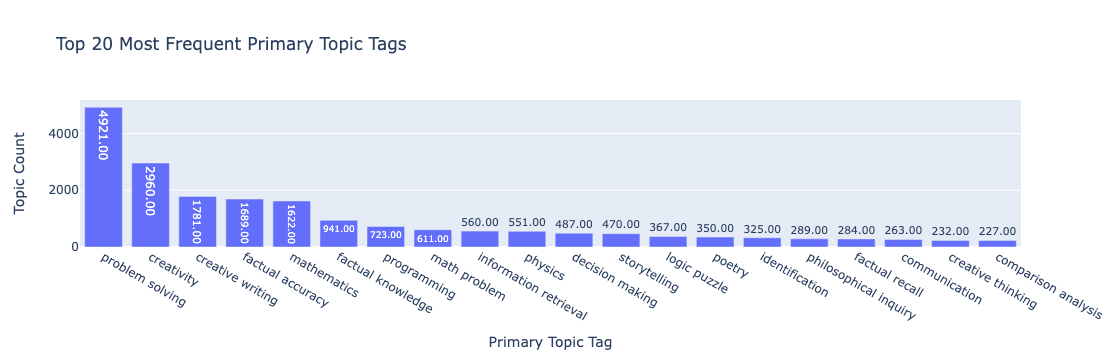

In [88]:
print("FIG. 10c")
# Same as above but calculates based on everything lowercase
# and separates by individual topic category,
# treating first item as primary topic

# Concatenate the three topic models columns
topic_and_hardness["topic_modeling_1_primary"] = topic_and_hardness["topic_modeling_1"].str.lower().str.replace('-', ' ').str.split(", ").str.get(0)
topic_and_hardness["topic_modeling_2_primary"] = topic_and_hardness['topic_modeling_2'].str.lower().str.replace('-', ' ').str.split(", ").str.get(0)
topic_and_hardness["topic_modeling_3_primary"] = topic_and_hardness['topic_modeling_3'].str.lower().str.replace('-', ' ').str.split(", ").str.get(0)
topic_and_hardness.head(3)

combined_topic_modeling_primary = pd.concat([topic_and_hardness['topic_modeling_1_primary'], topic_and_hardness['topic_modeling_2_primary'], topic_and_hardness['topic_modeling_3_primary']])
display(combined_topic_modeling_primary.value_counts())

# Look at the top 20 most frequent topics ()
top_20_topics_primary = combined_topic_modeling_primary.value_counts().head(20)
top_20_topics_primary

# Visualize top 20 most frequent topics
fig_10c = px.bar(top_20_topics_primary.sort_values(ascending=False),
             title="Top 20 Most Frequent Primary Topic Tags",
             text_auto=".2f")
fig_10c.update_layout(yaxis_title="Topic Count", xaxis_title="Primary Topic Tag",
                  showlegend=False)
fig_10c

In [89]:
# Combine the mean and frequency count of each topic across all topic_modeling columns
topic_and_hardness['topic_modeling_1'] = topic_and_hardness['topic_modeling_1'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
topic_and_hardness['topic_modeling_1'] = topic_and_hardness['topic_modeling_1'].str.lower()

topic_1 = topic_and_hardness.groupby("topic_modeling_1")["score_value_1"].agg(['mean', 'count']).sort_values(by="mean", ascending=False).reset_index()

topic_and_hardness['topic_modeling_2'] = topic_and_hardness['topic_modeling_2'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
topic_and_hardness['topic_modeling_2'] = topic_and_hardness['topic_modeling_2'].str.lower()

topic_2 = topic_and_hardness.groupby("topic_modeling_2")["score_value_2"].agg(['mean', 'count']).sort_values(by="mean", ascending=False).reset_index()

topic_and_hardness['topic_modeling_3'] = topic_and_hardness['topic_modeling_3'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
topic_and_hardness['topic_modeling_3'] = topic_and_hardness['topic_modeling_3'].str.lower()

topic_3 = topic_and_hardness.groupby("topic_modeling_3")["score_value_3"].agg(['mean', 'count']).sort_values(by="mean", ascending=False).reset_index()

In [90]:
# Merge dataframes to create one dataframe with all the topics, means, and frequency counts
topic_1_and_2 = topic_1.merge(topic_2, left_on = "topic_modeling_1", right_on = "topic_modeling_2")
topic_1_and_2

all_topics = topic_1_and_2.merge(topic_3, left_on = "topic_modeling_1", right_on = "topic_modeling_3")
all_topics["count"] = all_topics["count_x"] + all_topics["count_y"] + all_topics["count"]
all_topics["mean"] = (all_topics["mean_x"] + all_topics["mean_y"] + all_topics["mean"]) / 3
all_topics = all_topics.drop(["mean_x", "count_x", "mean_y", "count_y", "topic_modeling_2", "topic_modeling_3"], axis=1)
all_topics = all_topics.rename(columns = {"topic_modeling_1": "topic_modeling", "mean": "average hardness score", "count": "frequency"})

all_topics

topic_modeling  average hardness score  frequency
0     programming equivalency                    8.33          3
1               training plan                    8.50          6
2            training program                    8.17          5
3              medical report                    8.83          4
4         medical translation                    9.00          3
...                       ...                     ...        ...
3849   cybersecurity, hacking                    1.11          6
3850               dark humor                    2.17          4
3851          casual greeting                    1.00          4
3852      casual conversation                    1.50         10
3853               skin color                    1.33          3

[3854 rows x 3 columns]

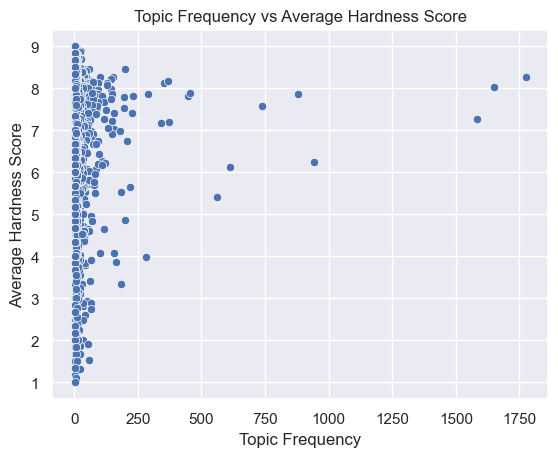

In [91]:
# Is there a relationship between average hardness score and frequency of topic?
sns.scatterplot(data = all_topics, x = "frequency", y = "average hardness score")
plt.xlabel("Topic Frequency")
plt.ylabel("Average Hardness Score")
plt.title("Topic Frequency vs Average Hardness Score");

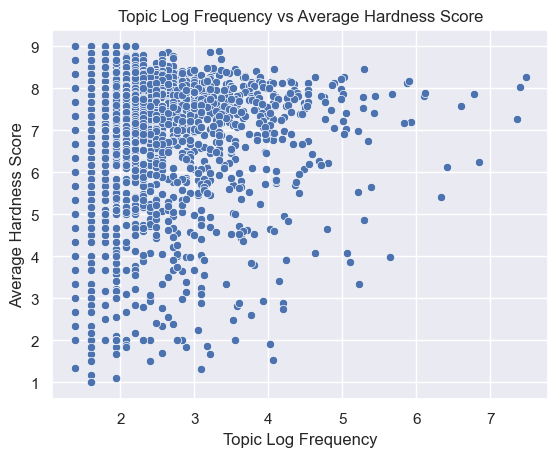

In [92]:
# Apply a log transformation for better visualization
all_topics['log_frequency'] = np.log1p(all_topics['frequency'])

sns.scatterplot(data = all_topics, x = "log_frequency", y = "average hardness score")
plt.xlabel("Topic Log Frequency")
plt.ylabel("Average Hardness Score")
plt.title("Topic Log Frequency vs Average Hardness Score");

FIG. 12


<Figure size 2000x1200 with 0 Axes>

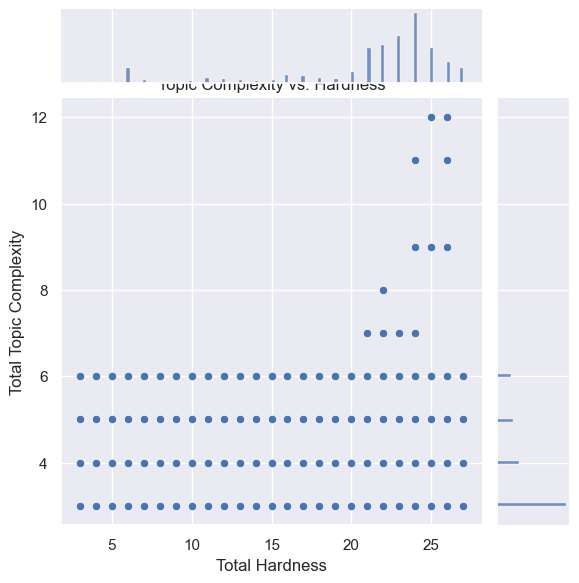

In [93]:
print("FIG. 12")

# Is there a relationship between number of topics ("topic modeling complexity") and total hardness score?
# ie: does having more than one topic listed affect the hardness score?

plt.figure(figsize=(20,12))
# Concatenate the three topic models columns
topic_and_hardness["topic_modeling_1_complexity"] = topic_and_hardness["topic_modeling_1"].astype(str).str.lower().str.split(", ").apply(lambda x: len(x))
topic_and_hardness["topic_modeling_2_complexity"] = topic_and_hardness["topic_modeling_2"].astype(str).str.lower().str.split(", ").apply(lambda x: len(x))
topic_and_hardness["topic_modeling_3_complexity"] = topic_and_hardness["topic_modeling_3"].astype(str).str.lower().str.split(", ").apply(lambda x: len(x))
topic_and_hardness["total_topic_complexity"] = topic_and_hardness["topic_modeling_1_complexity"] + topic_and_hardness["topic_modeling_2_complexity"] + topic_and_hardness["topic_modeling_3_complexity"]
topic_and_hardness["total_hardness"] = topic_and_hardness["score_value_1"] + topic_and_hardness["score_value_2"] + topic_and_hardness["score_value_3"]
topic_and_hardness.head()

sns.jointplot(data = topic_and_hardness, x = "total_hardness", y = "total_topic_complexity")

plt.title("Topic Complexity vs. Hardness")
plt.xlabel("Total Hardness")
plt.ylabel("Total Topic Complexity")
plt.show()

In [94]:
topic_and_hardness["total_topic_complexity"].value_counts()

total_topic_complexity
3     13728
4      4375
5      3130
6      2855
7         7
9         5
12        3
11        2
8         1
Name: count, dtype: int64

FIG. 13


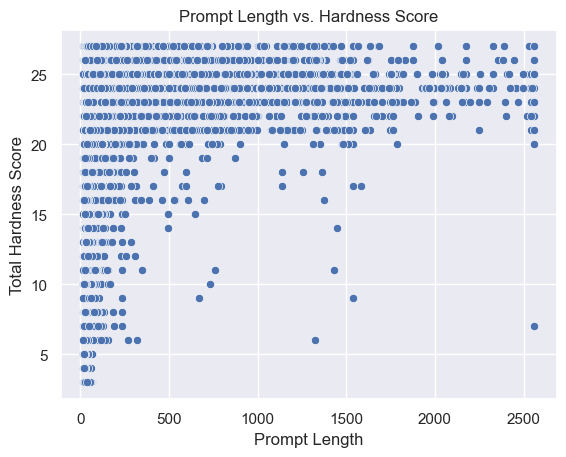

In [103]:
print("FIG. 13")

# Is there a relationship between length of prompt and hardness?

sns.scatterplot(x= conversations["prompt_length"], y = topic_and_hardness["total_hardness"])
plt.title("Prompt Length vs. Hardness Score")
plt.xlabel("Prompt Length")
plt.ylabel("Total Hardness Score")
plt.show()

***References:***

[1] N. Mehrabi, F. Morstatter, N. Saxena, K. Lerman, and A. Galstyan, "A Survey on Bias and Fairness in Machine Learning," arXiv:1908.09635v2 [cs.LG], Sep. 2019. Available: https://arxiv.org/abs/1908.09635

[2] C.-H. Chiang and H.-y. Lee, "Can Large Language Models Be an Alternative to Human Evaluation?" in Proceedings of the 61st Annual Meeting of the Association for Computational Linguistics (ACL), Volume 1: Long Papers, pp. 15607–15631, July 2023. Available: https://www.aclweb.org/anthology/2023.acl-long.870

[3] van der Lee, C., Gatt, A., van Miltenburg, E., & Krahmer, E. (2021). Human evaluation of automatically generated text: Current trends and best practice guidelines. Computer Speech &amp; Language, 67, 101151. doi:10.1016/j.csl.2020.101151

[4] W.-L. Chiang, L. Zheng, Y. Sheng, A. N. Angelopoulos, T. Li, D. Li, B. Zhu, H. Zhang, M. I. Jordan, J. E. Gonzalez, and I. Stoica, "Chatbot Arena: An Open Platform for Evaluating LLMs by Human Preference," arXiv:2403.04132v1 [cs.AI], Mar. 2024. Available: https://arxiv.org/abs/2403.04132